# Dev Model Compare Interactions

Written on Oct 31 2023 by Jess Breda.

The goal of this notebook is to write some new child classes for a model comparison experiment that can then be re-used for any model comparison experiment.

The specific comparison here is a model with violation history only and a model with violation history + viol history sa/sb interactions.

There are three main classes to write.


1. design matrix generator for violation history (most of this code comes form the base dmg class)
2. a model comparison experiment class
    - this will need to build off of the sigma sweep class to account for iterating over models and fitting a null model
3. a model vizualizer comparison class
    - this will re-format code that has been previously to allow for computing and plotting of bits/trial

In [2]:
import pandas as pd
import numpy as np

import pathlib
import sys
import seaborn as sns
from matplotlib import pyplot as plt

[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]

from design_matrix_generator import *
from get_rat_data import *
from fitting_utils import create_violation_interaction_pairs

sns.set_context("talk")
%load_ext autoreload
%autoreload 2

### Design Matrix Generator Violation History

In [23]:
animal_ids = ["W078"]

df = get_rat_viol_data(animal_ids)

returning viol data for ['W078']


In [6]:
X, y = DesignMatrixGeneratorViolationHistory("multi").generate_design_matrix(df, tau=7)

In [24]:
X2, y2 = DesignMatrixGeneratorInteractions("multi").generate_design_matrix(
    df,
    tau=7,
    filter_column="prev_violation",
    interaction_pairs=create_violation_interaction_pairs(["s_a", "s_b"]),
)

In [25]:
X.equals(X2.drop(columns=["prev_violation_exp_x_s_a", "prev_violation_exp_x_s_b"]))

True

Okay great- Now there is a class DesignMatrixGeneratorViolationHistory and given the same animal df and tau, the columns and labels generated are the same as DesignMatrixGeneratorInteractions when excluding interaction terms. This is due to both functions using the parent class to generate the base matrix and exp filter

### Model Compare Experiment Class

In [80]:
from experiment import Experiment
from multiclass_logistic_regression import MultiClassLogisticRegression
from binary_logistic_regression import BinaryLogisticRegression
from null_model import NullModel

In [29]:
params = {
    "animals": ["W078"],
    "sigmas": [0.07, 0.13],
    "random_state": 47,
    "null_model": "multi"
    "model_config": {
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorInteractions,
        "design_matrix_generator_args": {
            "filter_column": "prev_violation",
            "interaction_pairs": create_violation_interaction_pairs(["s_a", "s_b"]),
        },
    },
}

test = Experiment(params)

returning viol data for ['W078']


In [33]:
test.df

,animal_id,session,trial,s_a,s_b,choice,correct_side,hit,delay,training_stage,violation,n_trial,training_stage_cat
0,W078,1,1,NaN,NaN,1.0,0,0.0,1.0,1,False,1511189,1
1,W078,1,2,NaN,NaN,0.0,0,1.0,1.0,1,False,1511190,1
2,W078,1,3,NaN,NaN,0.0,0,1.0,1.0,1,False,1511191,1
3,W078,1,4,NaN,NaN,0.0,0,1.0,1.0,1,False,1511192,1
4,W078,1,5,NaN,NaN,1.0,1,1.0,1.0,1,False,1511193,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53294,W078,200,269,92.0,84.0,0.0,1,0.0,3.1,4,False,1564483,4
53295,W078,200,270,68.0,76.0,0.0,0,1.0,2.1,4,False,1564484,4
53296,W078,200,271,68.0,60.0,NaN,1,NaN,3.1,4,True,1564485,4
53297,W078,200,272,60.0,68.0,NaN,0,NaN,2.1,4,True,1564486,4


In [43]:
X3, y3 = test.generate_design_matrix_for_animal(
    test.df,
    tau=7,
)

In [40]:
X2.equals(X3), np.all(y2 == y3)

(True, True)

In [46]:
params = {
    "animals": ["W078"],
    "sigmas": [0.07, 0.13],
    "random_state": 47,
    "model_config": {
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorViolationHistory,
    },
}


test2 = Experiment(params)

X4, y4 = test2.generate_design_matrix_for_animal(
    test2.df,
    tau=7,
)

X4.equals(X), np.all(y == y4)

returning viol data for ['W078']


(True, True)

Next step: work on writing out the run_single_animal function for comparison experiment using the new parent class functions. Will need to write in a null model class into the part. Will need to take into account where/when train test splitting is happening.

In [3]:
from multiclass_logistic_regression import MultiClassLogisticRegression
from binary_logistic_regression import BinaryLogisticRegression
from design_matrix_generator import (
    DesignMatrixGeneratorViolationHistory,
    DesignMatrixGeneratorInteractions,
)

model_config = {
    "violation_history": {
        "model_class": MultiClassLogisticRegression,
        "model_type": "multi",
        "design_matrix_generator": DesignMatrixGeneratorViolationHistory,
    },
    "violation_stim_intrx": {
        "model_class": MultiClassLogisticRegression,
        "model_type": "mutli",
        "design_matrix_generator": DesignMatrixGeneratorInteractions,
        "design_matrix_generator_args": {
            "filter_column": "prev_violation",
            "interaction_pairs": create_violation_interaction_pairs(["s_a", "s_b"]),
        },
    },
}
params = {
    "animals": ["W078", "W075"],
    "sigmas": [0.07, 0.13, 13],
    "random_state": 47,
    "null_mode": "multi",
    "model_config": model_config,
}

In [4]:
from experiment_compare_models import ExperimentCompareModels

exp = ExperimentCompareModels(params)

exp.run()

returning viol data for ['W078', 'W075']

 >>>> evaluating animal W078 <<<<

 ***** evaluating model violation_history w/ sigma 0.07 *****
         Current function value: 27335.333531
         Iterations: 22
         Function evaluations: 37
         Gradient evaluations: 37

 ***** evaluating model violation_history w/ sigma 0.13 *****
         Current function value: 26938.678805
         Iterations: 23
         Function evaluations: 87
         Gradient evaluations: 75

 ***** evaluating model violation_history w/ sigma 13 *****
Optimization terminated successfully.
         Current function value: 26722.662774
         Iterations: 22
         Function evaluations: 34
         Gradient evaluations: 34

 ***** evaluating model violation_stim_intrx w/ sigma 0.07 *****
         Current function value: 27304.057314
         Iterations: 30
         Function evaluations: 105
         Gradient evaluations: 93

 ***** evaluating model violation_stim_intrx w/ sigma 0.13 *****
         Curre

In [5]:
exp.fit_models

,animal_id,model_name,model_type,nll,sigma,tau,features,weights,n_train_trials,n_test_trials
0,W078,violation_history,multi,7548.797155,0.07,2,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.36764294740206527, 0.36348350802655865, -0...",31403,8461
1,W078,violation_history,multi,7537.452885,0.13,2,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.3968193098436286, 0.4118227295445373, -0.8...",31403,8461
2,W078,violation_history,multi,7542.453844,13,2,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.41510302455577597, 0.4456860494159835, -0....",31403,8461
3,W078,violation_stim_intrx,mutli,7526.359831,0.07,2,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.3656597605097624, 0.3617417966782676, -0.7...",31403,8461
4,W078,violation_stim_intrx,mutli,7503.648327,0.13,2,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.39188986116352603, 0.4056021671930218, -0....",31403,8461
5,W078,violation_stim_intrx,mutli,7499.068803,13,2,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.4075222596744689, 0.43320663998078235, -0....",31403,8461
6,W075,violation_history,multi,10106.856706,0.07,6,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.31101901635185636, 0.2704928878705004, -0....",45703,10832
7,W075,violation_history,multi,10072.359885,0.13,6,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.36978768596990524, 0.30851559862993844, -0...",45703,10832
8,W075,violation_history,multi,10061.47737,13,6,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.41196504909903636, 0.335382790455736, -0.7...",45703,10832
9,W075,violation_stim_intrx,mutli,10100.340021,0.07,6,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.31091194135707795, 0.2694342230683333, -0....",45703,10832


In [6]:
exp.null_models

,animal_id,model_name,model_type,nll,n_test_trials,n_train_trials,p_L,n_L,p_R,n_R,p_V,n_V
0,W078,null,multi,8727.677461,8461,31403,0.437419,3701,0.390734,3306,0.171847,1454
1,W075,null,multi,11412.302219,10832,45703,0.397434,4305,0.404450,4381,0.198117,2146


Okay great- a new experiment has been made and put into it's own .py file. The output looks as expected for both the fitted & null models. Now, lets build a new ModelVisualizer class specifically for comparing. This class will need to: 

1. compute the bits per trial df 
    - merging the fit & null model dfs
2. plot model comparison

In [7]:
from model_visualizer import ModelVisualizerCompare

mvc = ModelVisualizerCompare(exp)

,animal_id,model_name,model_type,nll,sigma,tau,features,weights,n_train_trials,n_test_trials
0,W075,violation_history,multi,10061.477370,13.00,6.0,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.41196504909903636, 0.335382790455736, -0.7...",45703,10832
1,W075,violation_stim_intrx,mutli,10044.662347,13.00,6.0,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.41056371097206024, 0.326906301554999, -0.7...",45703,10832
2,W078,violation_history,multi,7537.452885,0.13,2.0,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.3968193098436286, 0.4118227295445373, -0.8...",31403,8461
3,W078,violation_stim_intrx,mutli,7499.068803,13.00,2.0,"[bias, s_a, s_b, prev_sound_avg, prev_correct,...","[[0.4075222596744689, 0.43320663998078235, -0....",31403,8461


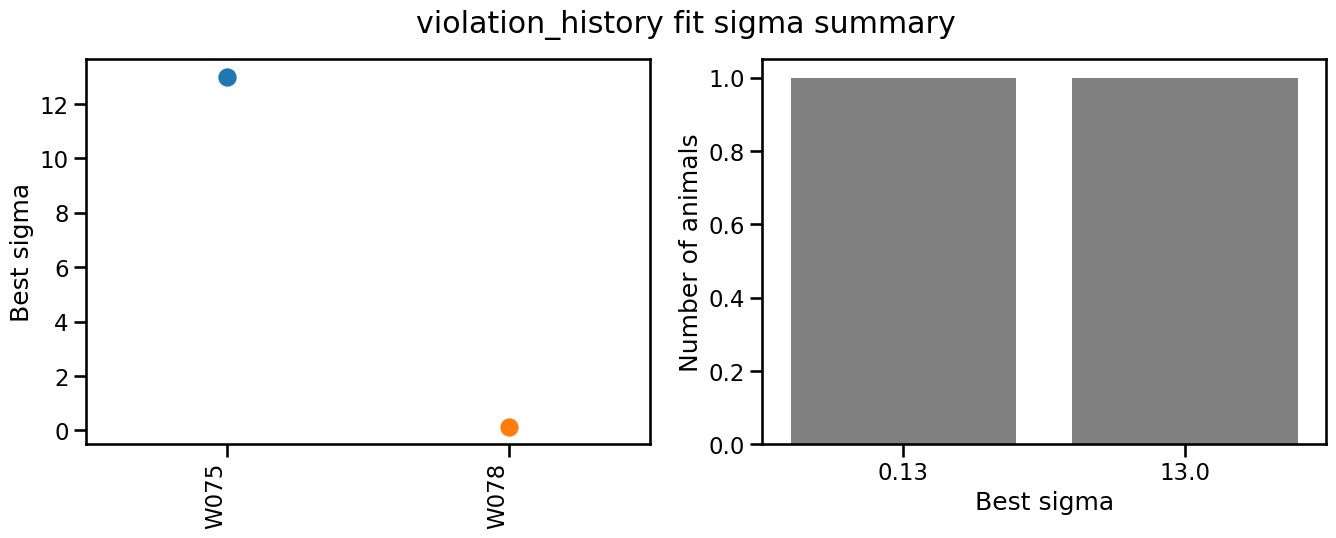

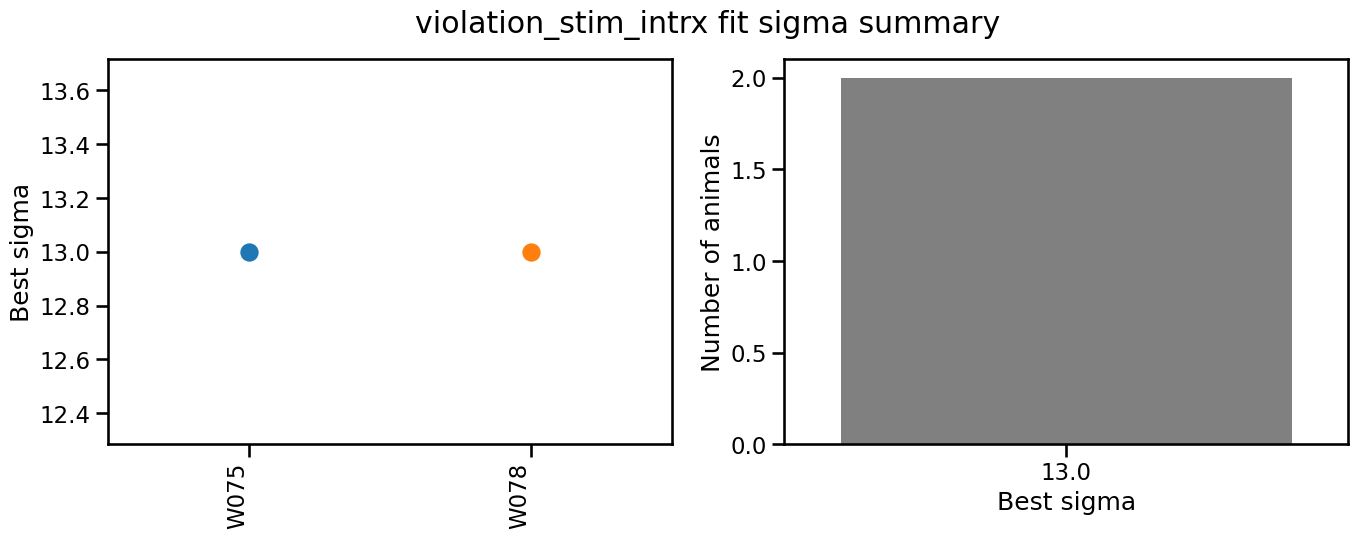

In [19]:
for model_name, model_df in df.groupby("model_name"):
    # TODO- would be nice to clean this up so it's just one plot with a hue as model_name.
    # TODO might need to re-write in MVC or add more flexibility in parent
    mvc.plot_sigma_summary(model_df, title=f"{model_name} fit sigma summary")

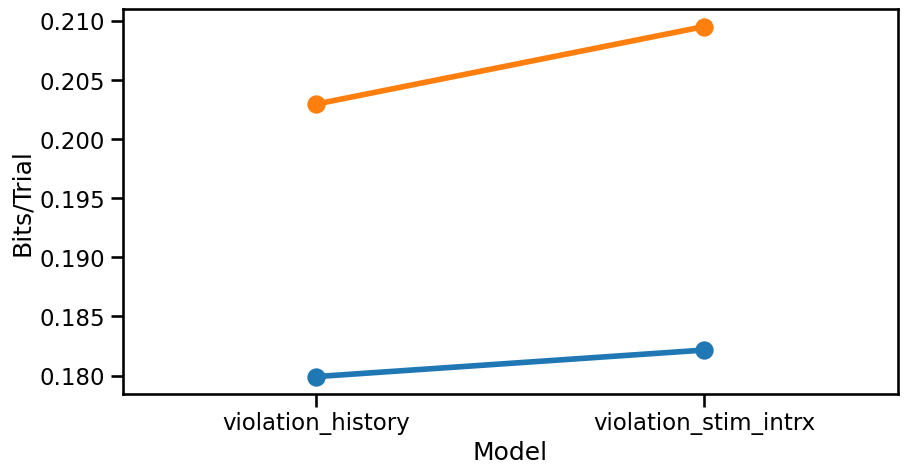

In [20]:
mvc = ModelVisualizerCompare(exp)
mvc.plot_model_comparison(hue="animal_id")

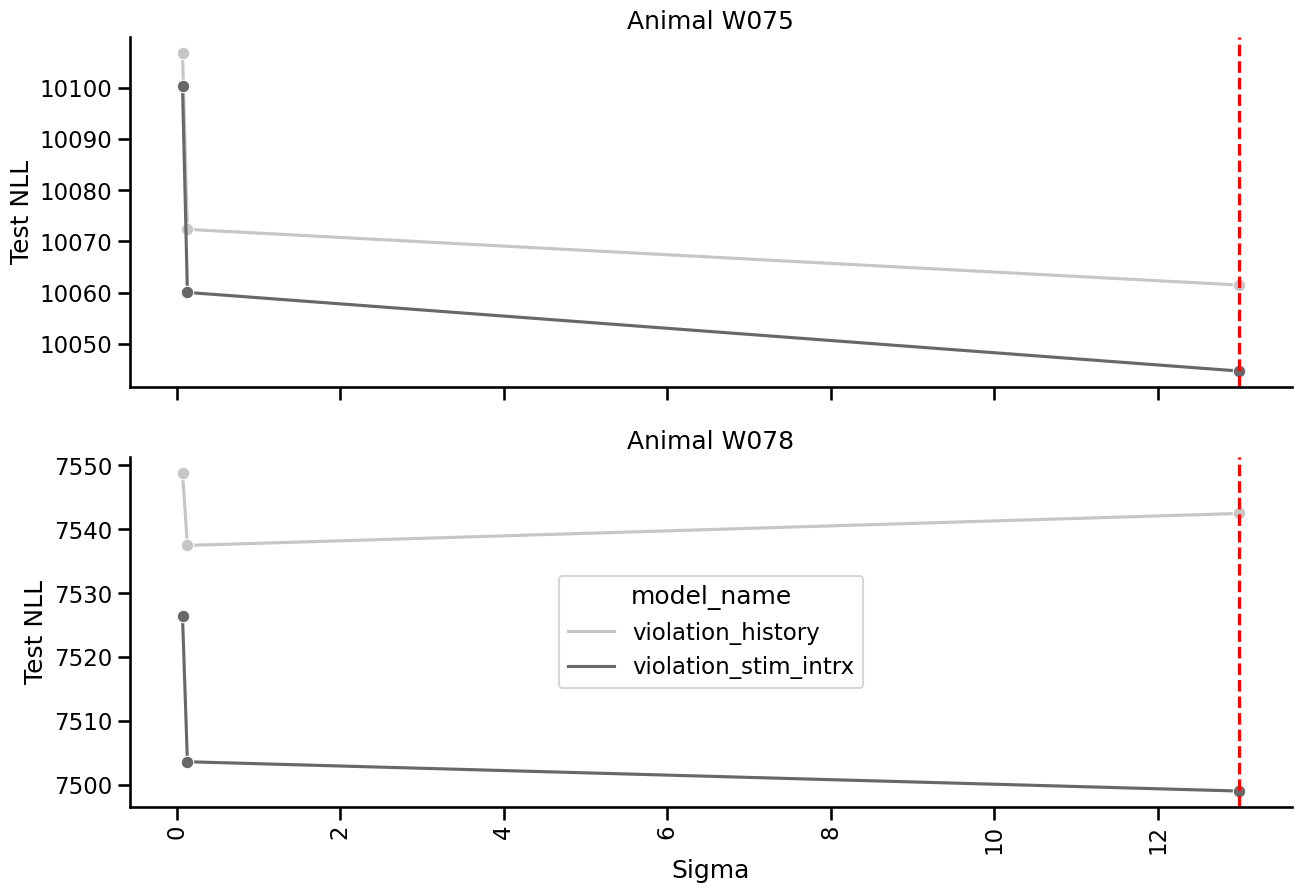

In [9]:
mvc.plot_nll_over_sigmas_by_animal_by_model()

In [14]:
df = mvc.find_best_fit(group="model_name")

violation_history
violation_stim_intrx


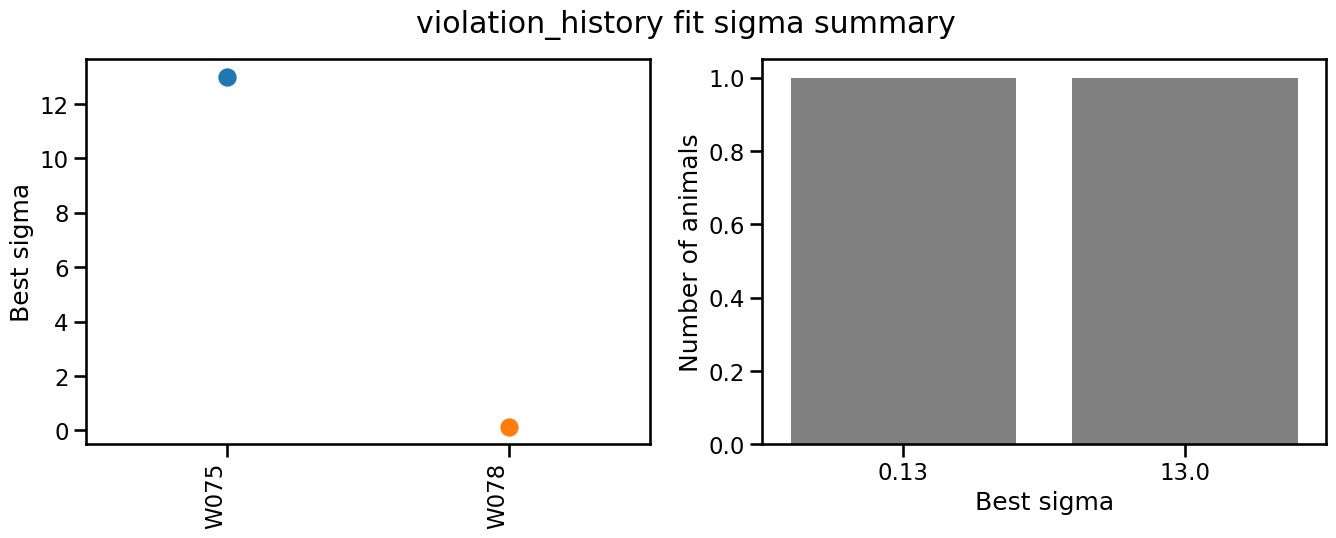

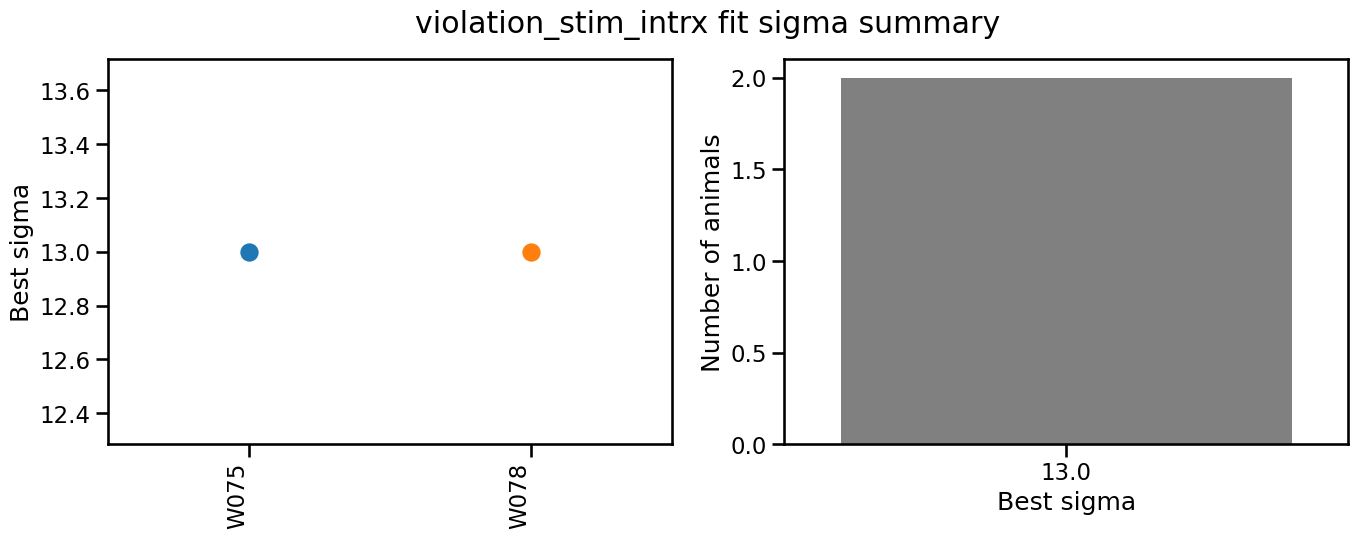

In [16]:
for model_name, model_df in df.groupby("model_name"):
    print(model_name)
    mvc.plot_sigma_summary(model_df, title=f"{model_name} fit sigma summary")